In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calendar
from datetime import date
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing


In [48]:
df = pd.read_csv('data/cleaned_data.csv')

In [49]:
df.head()

,Order Date,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales
0,2017-08-11,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2017-08-11,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,2017-12-06,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,2016-11-10,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,2016-11-10,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [85]:
print("number of States: ",df['State'].nunique())

number of States:  49


In [51]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [52]:
df['Month'] = df['Order Date'].dt.month

In [53]:
df['Year'] = df['Order Date'].dt.year

In [54]:
df['Day'] = df['Order Date'].dt.day

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9799 entries, 0 to 9798
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    9799 non-null   datetime64[ns]
 1   Segment       9799 non-null   object        
 2   City          9799 non-null   object        
 3   State         9799 non-null   object        
 4   Region        9799 non-null   object        
 5   Category      9799 non-null   object        
 6   Sub-Category  9799 non-null   object        
 7   Product Name  9799 non-null   object        
 8   Sales         9799 non-null   float64       
 9   Month         9799 non-null   int64         
 10  Year          9799 non-null   int64         
 11  Day           9799 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 918.8+ KB


In [56]:
df.head()

,Order Date,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales,Month,Year,Day
0,2017-08-11,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,8,2017,11
1,2017-08-11,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,8,2017,11
2,2017-12-06,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,12,2017,6
3,2016-11-10,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,11,2016,10
4,2016-11-10,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,11,2016,10


In [57]:
df.set_index(df['Order Date'].apply(lambda x: x.strftime('%Y-%m')), inplace=True)

# drop the original date column
df.drop('Order Date', axis=1, inplace=True)


In [58]:
df.drop(['Month','Year'],inplace=True,axis=1)

In [59]:
df.head()

,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales,Day
Order Date,,,,,,,,,
2017-08,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,11
2017-08,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,11
2017-12,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,6
2016-11,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,10
2016-11,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,10


In [60]:
df.index = pd.to_datetime(df.index)

In [61]:
# group the data by month and calculate the total sales
df_monthly = df.groupby(pd.Grouper(freq='M'))['Sales'].sum()

# convert the resulting Series to a dataframe
df_monthly = pd.DataFrame(df_monthly)

# display the data
print(df_monthly)


                 Sales
Order Date            
2015-01-31  28828.2540
2015-02-28  12588.4840
2015-03-31  54027.6920
2015-04-30  24428.6440
2015-05-31  29520.4900
2015-06-30  29181.3346
2015-07-31  35194.5580
2015-08-31  37349.2655
2015-09-30  65956.3998
2015-10-31  34561.9470
2015-11-30  64369.4565
2015-12-31  63568.3107
2016-01-31  29347.3864
2016-02-29  20728.3520
2016-03-31  34489.6776
2016-04-30  38056.9685
2016-05-31  30761.5585
2016-06-30  28515.9082
2016-07-31  28573.3100
2016-08-31  49076.9300
2016-09-30  65352.9970
2016-10-31  31631.8890
2016-11-30  50009.1450
2016-12-31  52891.8832
2017-01-31  38048.1840
2017-02-28  48907.5900
2017-03-31  48990.1410
2017-04-30  42368.0480
2017-05-31  64836.2518
2017-06-30  37424.6810
2017-07-31  41761.9430
2017-08-31  45766.8144
2017-09-30  40692.3063
2017-10-31  52156.9580
2017-11-30  66392.5470
2017-12-31  72847.0855
2018-01-31  59767.0910
2018-02-28  48928.8334
2018-03-31  74748.6238
2018-04-30  37849.2156
2018-05-31  40882.4464
2018-06-30 

In [62]:
df_train = df.index< '2018-01-01'

df_test = df.index>= '2018-01-01'

In [63]:
df_train = df[df_train]

In [64]:
#print max index of train data
print(df_train.index.max())

2017-12-01 00:00:00


In [65]:
df_train.columns

Index(['Segment', 'City', 'State', 'Region', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Day'],
      dtype='object')

In [66]:
df_yearly_segment = df_train.groupby([pd.Grouper(freq='Y'), 'Segment'])['Sales'].sum().reset_index()

      
df_yearly_segment = pd.DataFrame(df_yearly_segment)

In [67]:
df_yearly_segment.head()

,Order Date,Segment,Sales
0,2015-12-31,Consumer,262956.8006
1,2015-12-31,Corporate,127797.4957
2,2015-12-31,Home Office,88820.5398
3,2016-12-31,Consumer,265356.2933
4,2016-12-31,Corporate,119675.5989


In [68]:
df_yearly_segment.head()

,Order Date,Segment,Sales
0,2015-12-31,Consumer,262956.8006
1,2015-12-31,Corporate,127797.4957
2,2015-12-31,Home Office,88820.5398
3,2016-12-31,Consumer,265356.2933
4,2016-12-31,Corporate,119675.5989


In [69]:
df_yearly_sales = df_train.groupby(pd.Grouper(freq='Y'))['Sales'].sum()
df_yearly_sales = pd.DataFrame(df_yearly_sales)

In [70]:
df_yearly_sales

,Sales
Order Date,
2015-12-31,479574.8361
2016-12-31,459436.0054
2017-12-31,600192.5500


In [71]:
df_yearly_sales.head()

,Sales
Order Date,
2015-12-31,479574.8361
2016-12-31,459436.0054
2017-12-31,600192.5500


<AxesSubplot: xlabel='Order Date'>

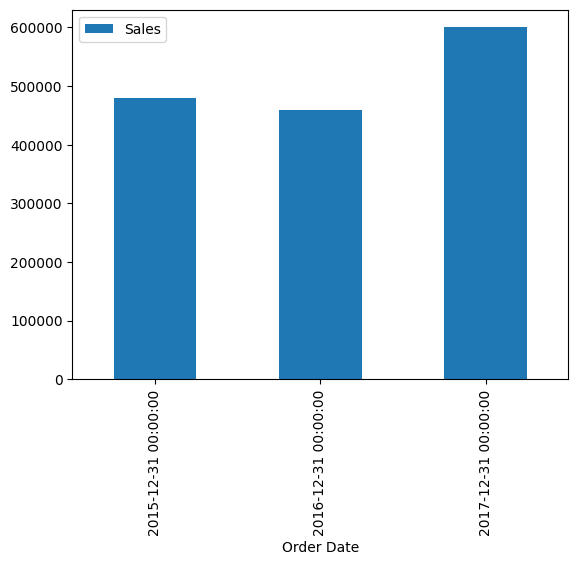

In [72]:
df_yearly_sales.plot(kind='bar')

<AxesSubplot: xlabel='Order Date'>

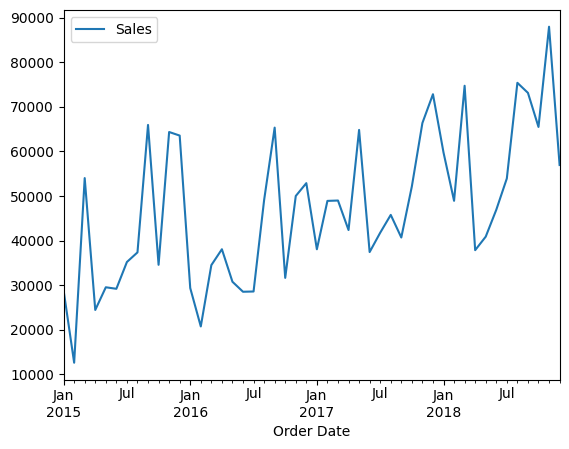

In [73]:
df_monthly.plot()

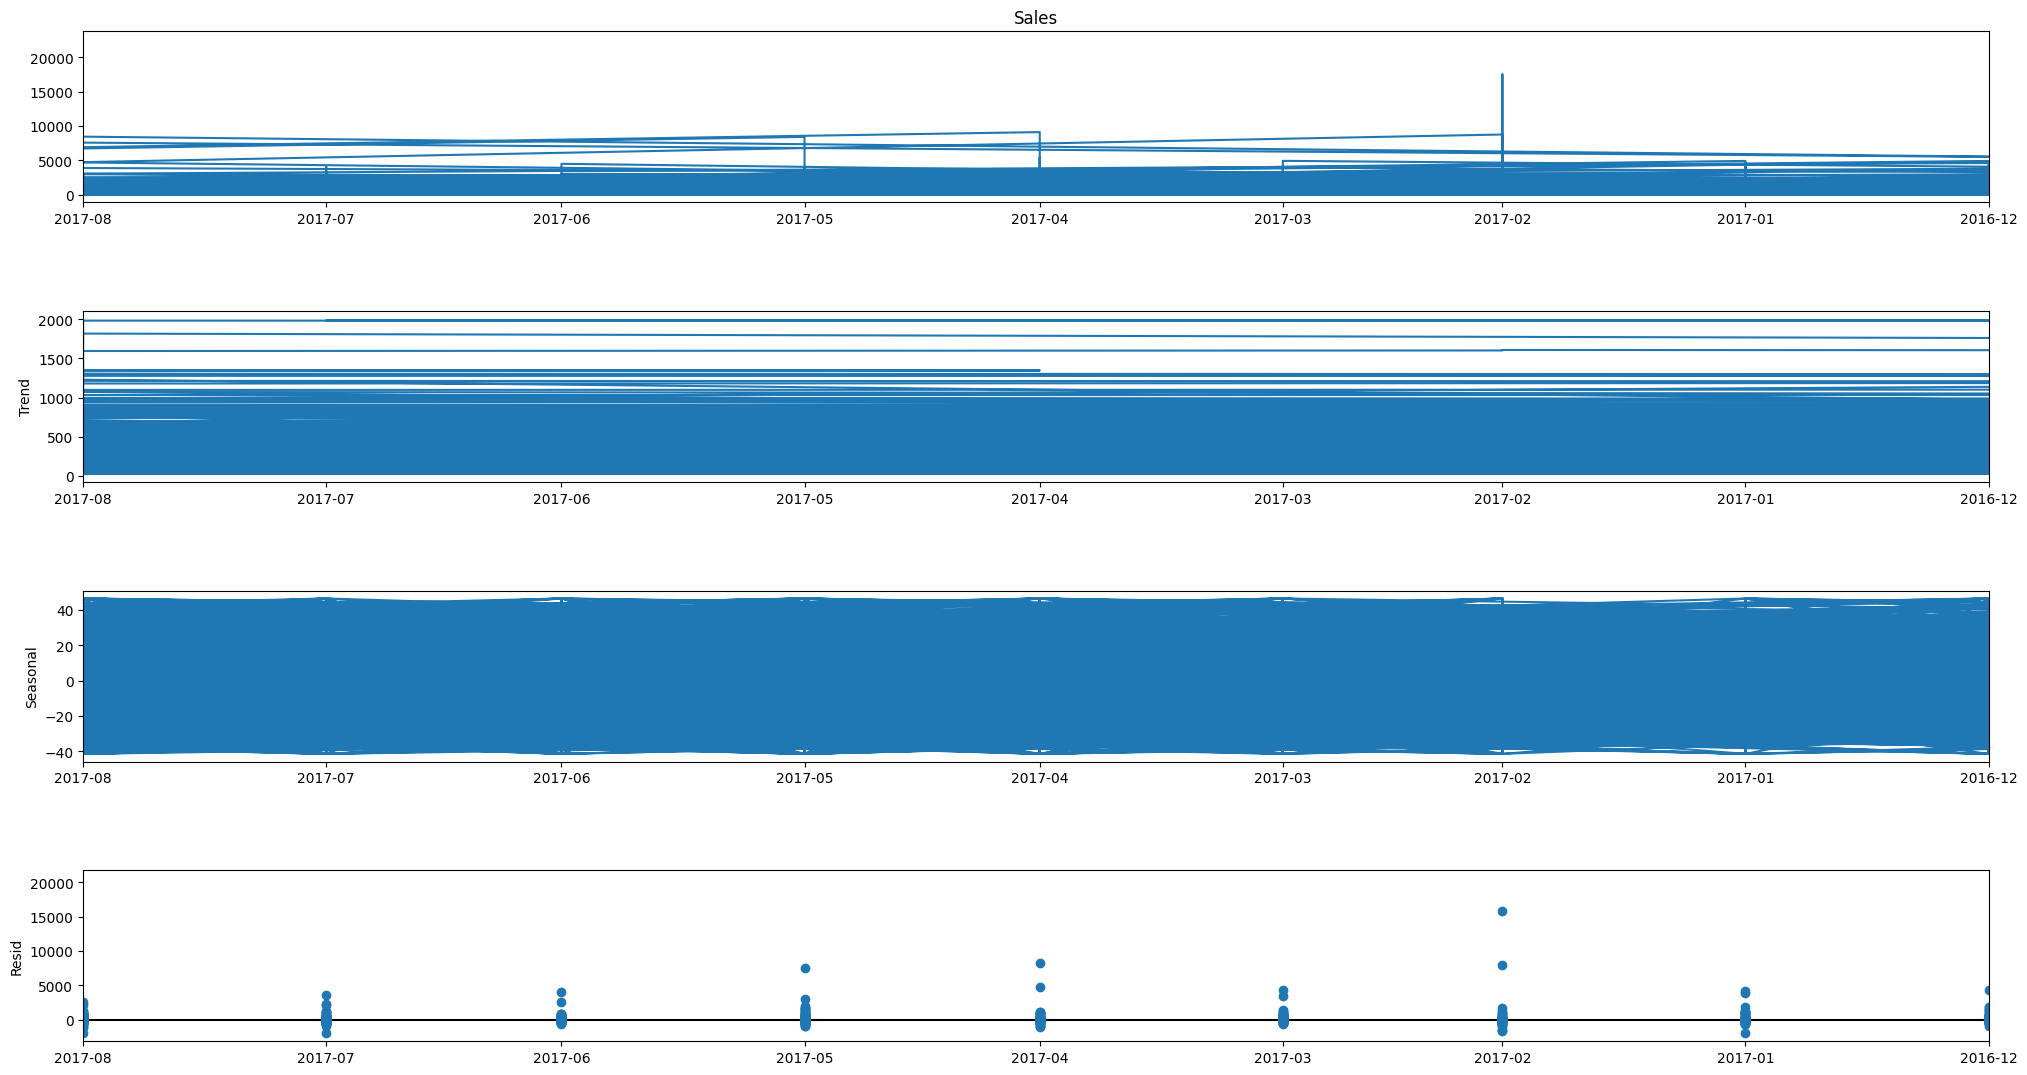

(Order Date
 2017-08-01   NaN
 2017-08-01   NaN
 2017-12-01   NaN
 2016-11-01   NaN
 2016-11-01   NaN
               ..
 2017-05-01   NaN
 2016-12-01   NaN
 2016-12-01   NaN
 2016-12-01   NaN
 2016-12-01   NaN
 Name: trend, Length: 9799, dtype: float64,
 Order Date
 2017-08-01   -27.254309
 2017-08-01    11.948899
 2017-12-01   -21.404043
 2016-11-01    -4.622291
 2016-11-01    22.561720
                 ...    
 2017-05-01   -21.404043
 2016-12-01    -4.622291
 2016-12-01    22.561720
 2016-12-01    31.092133
 2016-12-01   -41.488440
 Name: seasonal, Length: 9799, dtype: float64,
 Order Date
 2017-08-01   NaN
 2017-08-01   NaN
 2017-12-01   NaN
 2016-11-01   NaN
 2016-11-01   NaN
               ..
 2017-05-01   NaN
 2016-12-01   NaN
 2016-12-01   NaN
 2016-12-01   NaN
 2016-12-01   NaN
 Name: resid, Length: 9799, dtype: float64)

In [74]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df['Sales'], model='additive',period=12,)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(24, 12)
    plt.show()
    
    return trend, seasonal, residual
   
seasonal_decompose(df)

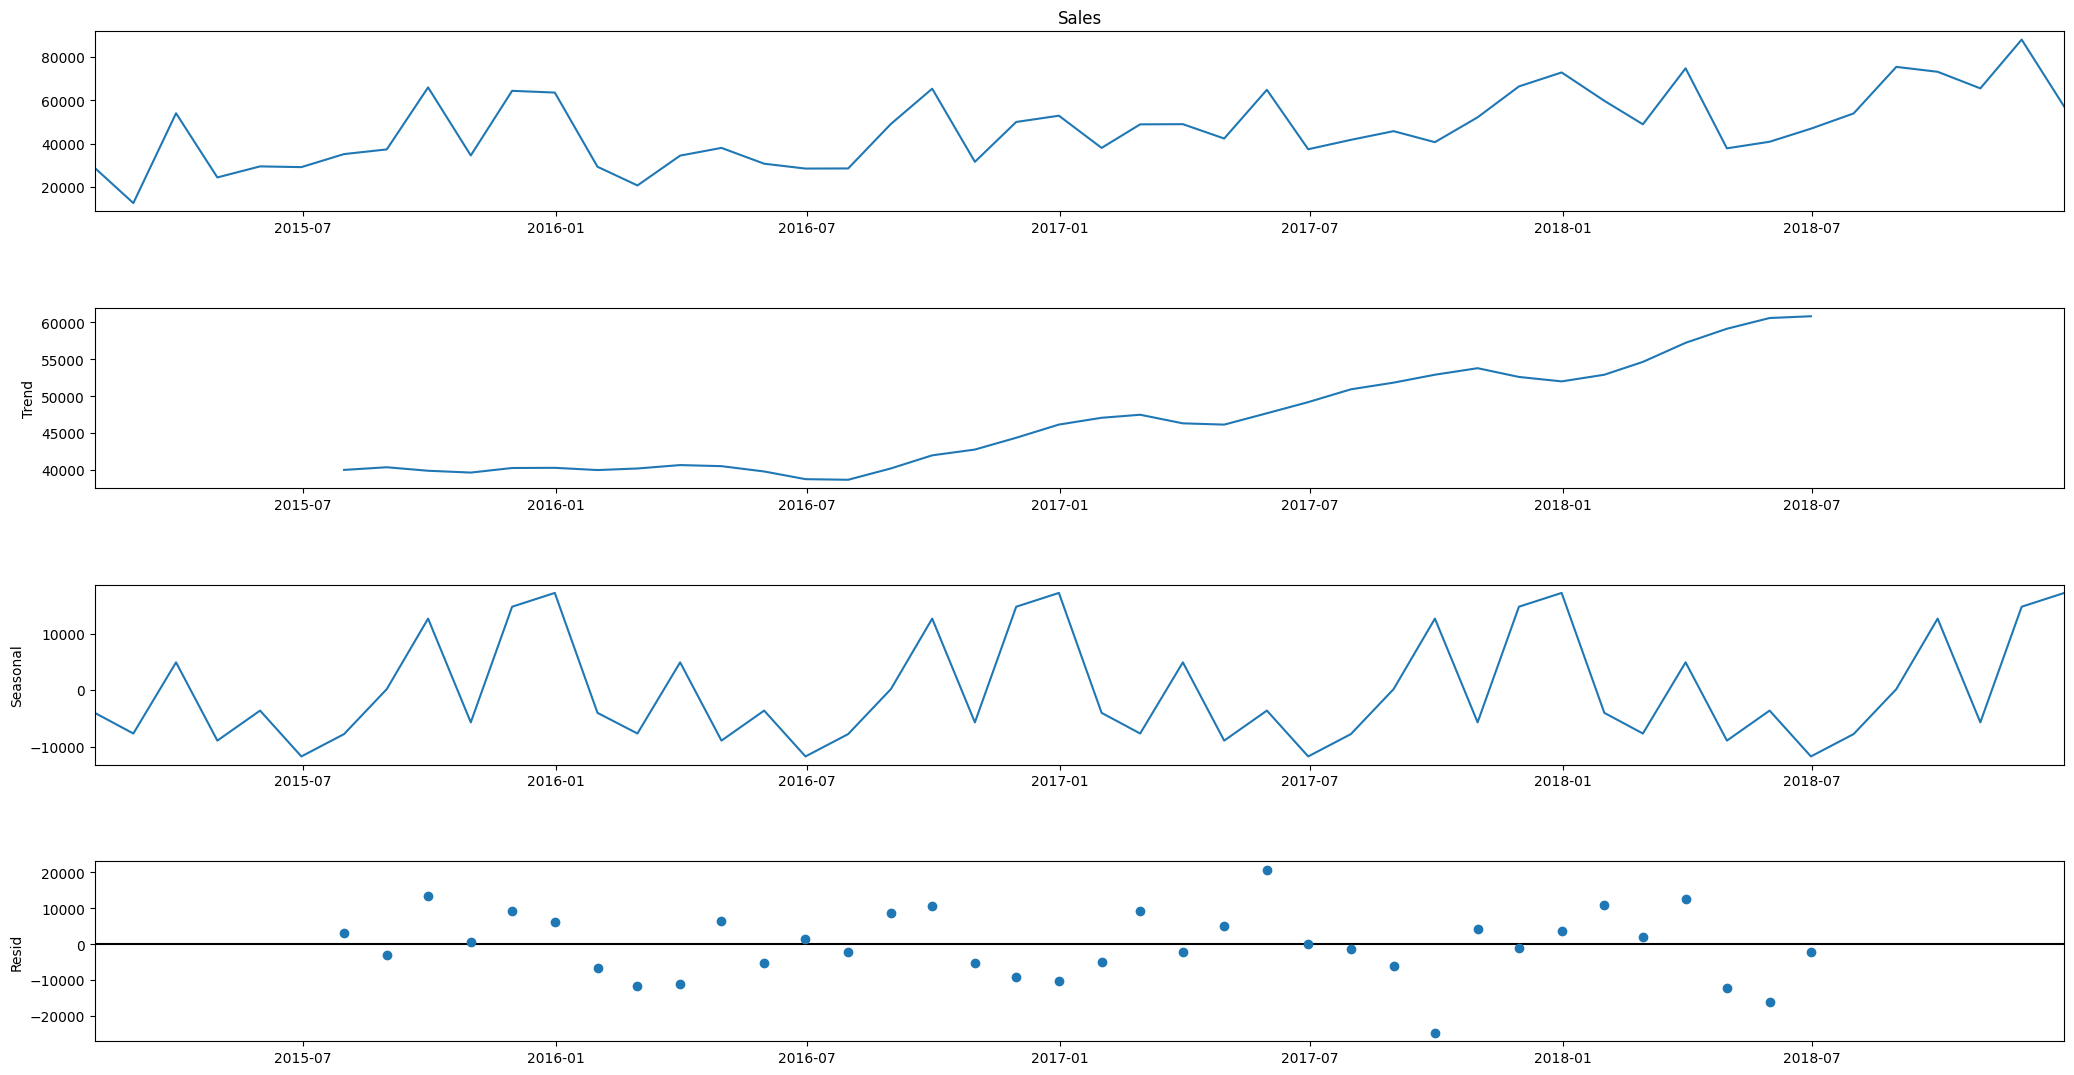

(Order Date
 2015-01-31             NaN
 2015-02-28             NaN
 2015-03-31             NaN
 2015-04-30             NaN
 2015-05-31             NaN
 2015-06-30             NaN
 2015-07-31    39986.200192
 2015-08-31    40346.991875
 2015-09-30    39872.069108
 2015-10-31    39625.832029
 2015-11-30    40245.390071
 2015-12-31    40269.375158
 2016-01-31    39965.763725
 2016-02-29    40178.531079
 2016-03-31    40642.041983
 2016-04-30    40494.814450
 2016-05-31    39774.382388
 2016-06-30    38731.184929
 2016-07-31    38648.867017
 2016-08-31    40185.535167
 2016-09-30    41963.856058
 2016-10-31    42747.670346
 2016-11-30    44347.077546
 2016-12-31    46138.055300
 2017-01-31    47058.780542
 2017-02-28    47470.385433
 2017-03-31    46304.935171
 2017-04-30    46132.617600
 2017-05-31    47670.470558
 2017-06-30    49184.579071
 2017-07-31    50921.000292
 2017-08-31    51826.839892
 2017-09-30    52900.995150
 2017-10-31    53785.980583
 2017-11-30    52599.620675
 2017-12

In [75]:
seasonal_decompose(df_monthly)

In [76]:
df_monthly.head()

,Sales
Order Date,
2015-01-31,28828.254
2015-02-28,12588.484
2015-03-31,54027.692
2015-04-30,24428.644
2015-05-31,29520.490


In [77]:
y = df_monthly['Sales']
 
y_to_train = df_monthly['Sales'][:'2017-12-31']
y_to_test = df_monthly['Sales']['2018-01-31':]
seasonal_period = 12
predict_date = 12

In [78]:
df.head()

,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales,Day
Order Date,,,,,,,,,
2017-08-01,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,11
2017-08-01,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,11
2017-12-01,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,6
2016-11-01,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,10
2016-11-01,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,10


In [79]:
# group the data by day and calculate the total sales


In [80]:
df_daily = df.groupby(pd.Grouper(freq='Y'))['Sales'].sum()


In [81]:
df_daily = pd.DataFrame(df_daily)


In [82]:
from scipy.stats import boxcox
def boxcox_inverse(y_boxcox, lam):
    return (y_boxcox * lam + 1)**(1/lam)


In [83]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2015-01-31 to 2018-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 1.8 KB


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=12 and a Box-Cox transformation 0.25


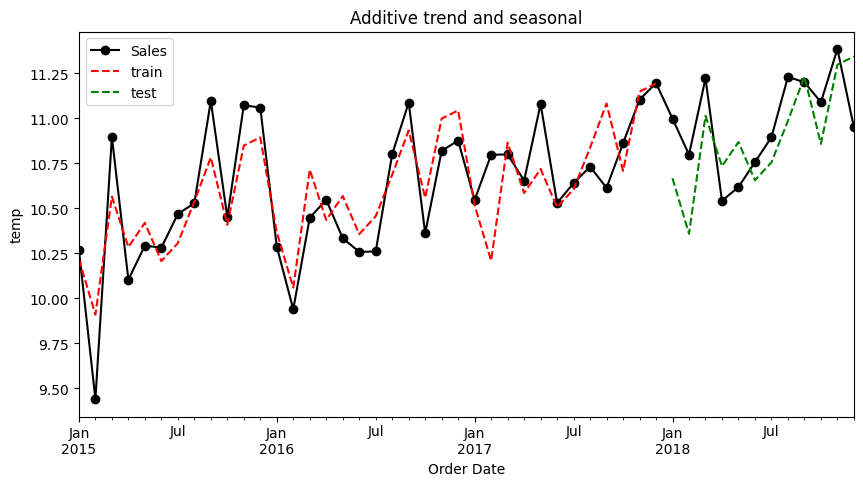

In [84]:

def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    y_to_train = y_to_train.apply(lambda x: np.log(x))
    y_to_test = y_to_test.apply(lambda x: np.log(x))
    y = y.apply(lambda x: np.log(x))
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='additive', seasonal='additive', damped_trend=False).fit() 
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    y.plot(marker='o', color='black', legend=True, figsize=(10, 5))
    fit1.fittedvalues.plot(style='--', color='red', label='train')
    fcast1.plot(style='--', color='green', label='test')
    plt.ylabel('temp')
    plt.title('Additive trend and seasonal')
    plt.legend()
    plt.show()
    
holt_win_sea(y, y_to_train, y_to_test, 12, 12)